In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import os

In [2]:
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette=sns.color_palette("Set2"))


In [3]:
working_folder = "."
figures_folder = working_folder + os.path.sep + 'figures' + os.path.sep
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)
abtest_metrics_df = pd.read_parquet(working_folder + os.path.sep + 'abtest_metrics_anonymised.parquet')

## parameters

In [4]:
alpha = 0.05

## function definitions

In [5]:
def mSPRT_vanilla_normal_p_value_aux(mean_x: float, mean_y: float, variance_x: float, variance_y: 
                                     float, count_x: float, count_y: float, theta_0: float = 0, tau_sq: float = 0.0001):
    
    if (count_x == 0) or (count_y == 0):
        return 1.0

    count_mean = 2 / (1/count_x + 1/count_y)

    test_statistic = (
      np.sqrt((variance_x + variance_y)/
              (variance_x + variance_y + count_mean * tau_sq)) *
      np.exp((count_mean ** 2.0 * tau_sq *
              (mean_y - mean_x - theta_0) ** 2.0) /
             (2.0 * (variance_x + variance_y) *
              (variance_x + variance_y + count_mean * tau_sq)))
    )
    return 1.0 / max(1.0, test_statistic)


## quality checks (to delete)

In [6]:
mSPRT_vanilla_normal_p_value_aux(0.5, 0.506, 0.25, 0.25, 200000, 100000, 0, 0.0001)

0.05148875397725761

In [7]:
abtest_metrics_df.count()

experiment_id       24161
variant_id          24161
metric_id           24161
time_since_start    24161
count_c             24161
count_t             24161
mean_c              24161
mean_t              24161
variance_c          23383
variance_t          23382
dtype: int64

In [8]:
abtest_metrics_df.drop_duplicates(['experiment_id', 'variant_id', 'metric_id', 'time_since_start']).count()

experiment_id       24153
variant_id          24153
metric_id           24153
time_since_start    24153
count_c             24153
count_t             24153
mean_c              24153
mean_t              24153
variance_c          23375
variance_t          23374
dtype: int64

TODO: Find the 8 duplicate rows

## Dataset descriptive statistics

### Reproduce the effect size distribution plot in the report "ASOS experimentation meta-analysis"

In [9]:
experiment_keys_overall_df = \
abtest_metrics_df \
.groupby(['experiment_id', 'variant_id', 'metric_id'])\
.agg({'time_since_start':'max'})

t_test_data_df = (
  experiment_keys_overall_df
  .reset_index()
  .merge(abtest_metrics_df, how='inner')
)


In [10]:
ttest_lambda = lambda x: scipy.stats.ttest_ind_from_stats(x['mean_c'],np.sqrt(x['variance_c']),
                                                          x['count_c'], x['mean_t'],
                                                          np.sqrt(x['variance_t']), x['count_t'],
                                                          equal_var=False)[1]

#scipy.stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=True, alternative='two-sided')

In [11]:
t_test_data_df['t-test-p-value']=t_test_data_df.apply(ttest_lambda, axis=1)
abtest_metrics_df = abtest_metrics_df.merge(t_test_data_df[['experiment_id', 'variant_id', 'metric_id','t-test-p-value']], 
                                            on=['experiment_id', 'variant_id', 'metric_id'])

metric_id 1


<Figure size 432x288 with 0 Axes>

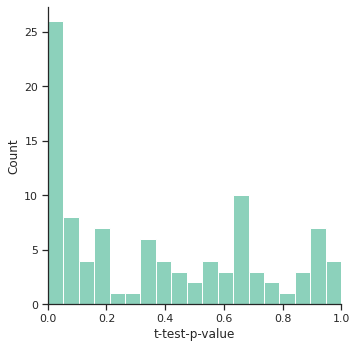

metric_id 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

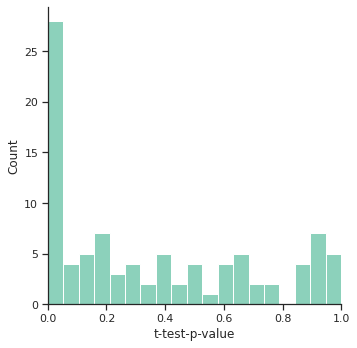

metric_id 3


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

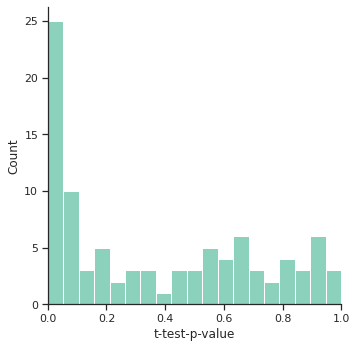

metric_id 4


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

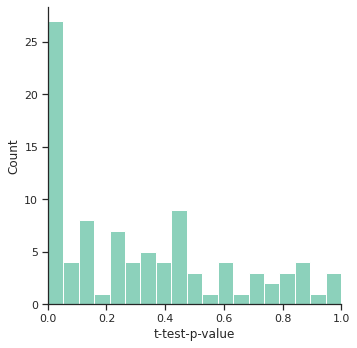

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

for metric_id in t_test_data_df['metric_id'].unique():
    print('metric_id', metric_id)
    plt.figure()
    sns.displot(t_test_data_df[t_test_data_df['metric_id']==metric_id]['t-test-p-value'],bins=np.linspace(0,1,20),rug=False,kde=False)
    #axlabel='Metric: '+ str(metric_id)
    plt.xlim(0, 1)
    plt.show()
    plt.savefig(figures_folder + 't-test_p-value_metric_' + str(metric_id) + '.pdf')



Calculate mSPRT p-value for ALL rows  
Calculate Bayesian A/B test Bayes Factor + Posterior Odds for ALL rows  
Calculate % experiemnt progress (i.e. time_since_start / max(time_since_start))

In [13]:
abtest_metrics_df['mSPRT-vanilla-p-value-aux'] = (
  abtest_metrics_df.apply(
    lambda row: mSPRT_vanilla_normal_p_value_aux(
      mean_x=row['mean_c'], mean_y=row['mean_t'],
      variance_x=row['variance_c'], variance_y=row['variance_t'],
      count_x=row['count_c'], count_y=row['count_t'],
      theta_0=0, tau_sq=0.0001),
    axis=1)
)


In [14]:
abtest_metrics_df = abtest_metrics_df.sort_values(['experiment_id', 'variant_id', 'metric_id'])

abtest_metrics_df['mSPRT-vanilla-p-value'] = (
  abtest_metrics_df
  .groupby(['experiment_id', 'variant_id', 'metric_id'])
  ['mSPRT-vanilla-p-value-aux']
  .transform(lambda row: row.expanding(min_periods=2).min())
)

abtest_metrics_df['mSPRT-vanilla-p-value'] = (
  abtest_metrics_df['mSPRT-vanilla-p-value'].fillna(1.0)
)


In [15]:
abtest_metrics_df = abtest_metrics_df.merge(abtest_metrics_df.groupby(['experiment_id', 'variant_id', 'metric_id'])\
                                            ['time_since_start'].max().reset_index()\
                                            .rename(columns={'time_since_start':'design_duration'}),on=['experiment_id', 'variant_id', 'metric_id'])
abtest_metrics_df['time_progress'] = abtest_metrics_df['time_since_start']/abtest_metrics_df['design_duration']
abtest_metrics_df['experiment_variant_id'] = abtest_metrics_df['experiment_id'].map(str) + '-' + abtest_metrics_df['variant_id'].map(str)

In [16]:
abtest_metrics_df

,experiment_id,variant_id,metric_id,time_since_start,count_c,count_t,mean_c,mean_t,variance_c,variance_t,t-test-p-value,mSPRT-vanilla-p-value-aux,mSPRT-vanilla-p-value,design_duration,time_progress,experiment_variant_id
0,036afc,2,1,1.5,188065.0,186686.0,0.107808,0.107828,0.096186,0.096201,4.558169e-01,1.000000,1.000000,76.5,0.019608,036afc-2
1,036afc,2,1,2.0,245041.0,243694.0,0.131790,0.131435,0.114422,0.114160,4.558169e-01,1.000000,1.000000,76.5,0.026144,036afc-2
2,036afc,2,1,2.5,277237.0,275949.0,0.143065,0.142711,0.122598,0.122345,4.558169e-01,1.000000,1.000000,76.5,0.032680,036afc-2
3,036afc,2,1,3.0,315689.0,314676.0,0.161789,0.160997,0.135613,0.135077,4.558169e-01,1.000000,1.000000,76.5,0.039216,036afc-2
4,036afc,2,1,3.5,338631.0,337715.0,0.172474,0.171067,0.142727,0.141803,4.558169e-01,1.000000,1.000000,76.5,0.045752,036afc-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24156,fdaf62,1,4,28.0,2182559.0,2180705.0,38.270483,38.858464,8478.894092,8708.839083,5.541495e-12,0.764372,0.764372,32.0,0.875000,fdaf62-1
24157,fdaf62,1,4,29.0,2259937.0,2257899.0,38.485748,39.065107,8627.264583,8821.982824,5.541495e-12,0.762436,0.762436,32.0,0.906250,fdaf62-1
24158,fdaf62,1,4,30.0,2341537.0,2339309.0,38.691410,39.211843,8916.435308,8848.559719,5.541495e-12,0.798158,0.762436,32.0,0.937500,fdaf62-1
24159,fdaf62,1,4,31.0,2422152.0,2419745.0,38.705264,39.263485,8836.078773,8884.955277,5.541495e-12,0.755721,0.755721,32.0,0.968750,fdaf62-1


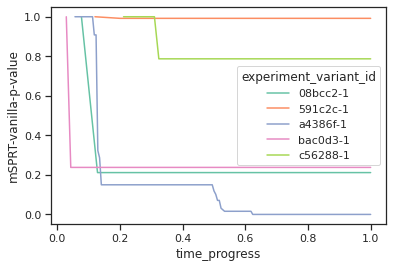

In [17]:
sns.lineplot(x="time_progress", y="mSPRT-vanilla-p-value",
             hue="experiment_variant_id",
             data=abtest_metrics_df[(abtest_metrics_df.experiment_variant_id.isin(['c56288-1', 'a4386f-1', 'bac0d3-1', '08bcc2-1', '591c2c-1'])) & (abtest_metrics_df.metric_id==1)])

plt.savefig(figures_folder + 'time_progress_significance_metric_' + str(metric_id) + '.pdf')


In [18]:


abtest_metrics_df['Both significant']=(abtest_metrics_df['t-test-p-value']<=alpha) & \
    (abtest_metrics_df['mSPRT-vanilla-p-value']<=alpha)
abtest_metrics_df['Only mSPRT significant']=(abtest_metrics_df['t-test-p-value']>alpha) & \
    (abtest_metrics_df['mSPRT-vanilla-p-value']<=alpha)
abtest_metrics_df['Both not significant']=(abtest_metrics_df['t-test-p-value']>alpha) & \
    (abtest_metrics_df['mSPRT-vanilla-p-value']>alpha)
abtest_metrics_df['Only t-test significant']=(abtest_metrics_df['t-test-p-value']<=alpha) & \
    (abtest_metrics_df['mSPRT-vanilla-p-value']>alpha)


In [19]:
abtest_metrics_df[(abtest_metrics_df['time_progress']==1)].groupby('metric_id')[
    ['Both significant','Only mSPRT significant','Both not significant','Only t-test significant']].sum()

,Both significant,Only mSPRT significant,Both not significant,Only t-test significant
metric_id,,,,
1,16,2,71,10
2,17,14,53,10
3,14,5,64,11
4,5,2,65,22


In [20]:
nbins = 10
labels=['Both not significant','Only mSPRT significant','Only t-test significant','Both significant']
abtest_metrics_df['time_progress_bin'] = pd.cut(abtest_metrics_df['time_progress'], \
                                                np.linspace(0,1,nbins+1),retbins=False)

#count snapshots per time_bin
abtest_metrics_evol_df = abtest_metrics_df.groupby(['experiment_variant_id','time_progress_bin'])[['time_progress']]\
    .count().groupby('experiment_variant_id').min()\
    .rename(columns={'time_progress':'min_samples_in_time_bin'}).reset_index()

#filter experiment_variant_id that have at least one entry per time bin
abtest_metrics_evol_df = abtest_metrics_evol_df[
    abtest_metrics_evol_df['min_samples_in_time_bin']>=1][['experiment_variant_id']]


print('#experiments with at least one entry per time bin', len(abtest_metrics_evol_df['experiment_variant_id'].unique()))
abtest_metric_evol_df = abtest_metrics_df[['experiment_variant_id','metric_id','time_progress_bin']+ labels]\
.merge(abtest_metrics_evol_df,on='experiment_variant_id')\
    .groupby(['time_progress_bin','experiment_variant_id','metric_id']).last().reset_index()
abtest_metric_evol_df['time_progress_bin'] = [x.mid for x in abtest_metric_evol_df['time_progress_bin'].values]

abtest_metric_evol_df = abtest_metric_evol_df.groupby(['time_progress_bin','metric_id']).mean().reset_index()


#experiments with at least one entry per time bin 62


In [21]:
abtest_metric_evol_df

,time_progress_bin,metric_id,Both not significant,Only mSPRT significant,Only t-test significant,Both significant
0,0.05,1,0.725806,0.000000,0.225806,0.048387
1,0.05,2,0.629032,0.048387,0.274194,0.032258
2,0.05,3,0.725806,0.016129,0.209677,0.032258
3,0.05,4,0.693548,0.000000,0.274194,0.016129
4,0.15,1,0.725806,0.000000,0.177419,0.096774
5,0.15,2,0.580645,0.096774,0.225806,0.080645
6,0.15,3,0.709677,0.032258,0.177419,0.064516
7,0.15,4,0.693548,0.000000,0.274194,0.016129
8,0.25,1,0.725806,0.000000,0.161290,0.112903
9,0.25,2,0.548387,0.129032,0.209677,0.096774


metric_id 1


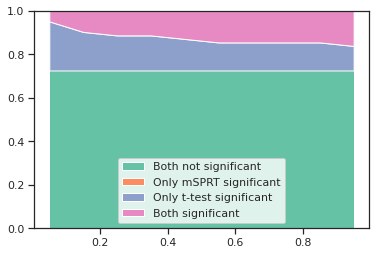

metric_id 2


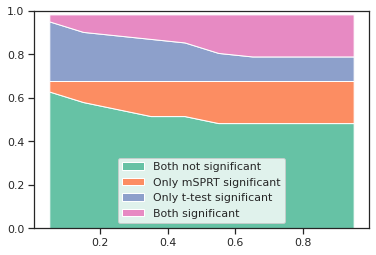

metric_id 3


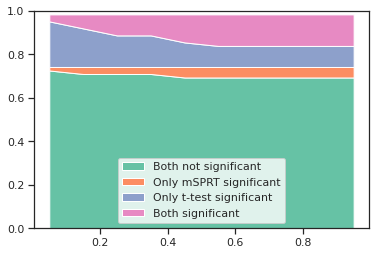

metric_id 4


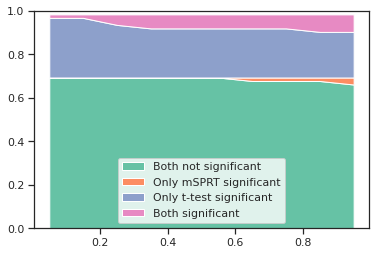

<Figure size 432x288 with 0 Axes>

In [22]:
for metric_id in abtest_metric_evol_df['metric_id'].unique():
    print('metric_id', metric_id)
    x=abtest_metric_evol_df['time_progress_bin'].unique()
    y = abtest_metric_evol_df[abtest_metric_evol_df['metric_id']==metric_id][labels].T.values

    # set seaborn style

    # Plot
    plt.stackplot(x,y, labels=labels)
    plt.ylim(0,1)

    plt.legend(loc='lower center')
    plt.show()
    plt.savefig(figures_folder + 'time_progress_type_metric_' + str(metric_id) + '.pdf')
    

Confusion matrix between Welch's t-test and mSPRT  
Confusion matrix between Welch's t-test and Bayesian A/B test



cumulative plot off type-I, type-II and correct rejection or no-rejection

Show data spike experiment, comment on how it affects mSPRT(vanilla), mSPRT(in deployment) and Bayesian A/B Test.

TODO: use markdown instead of cell title for export


TODO: TODO: Fix effective sample size n
TODO: estimate sigma^2 via whatever means